In [9]:
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tqdm.auto import tqdm

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

In [10]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data.pickle", "rb") as handle:
    oracle_reversed_random_data = pickle.load(handle)

with open("datasets/random_data.pickle", "rb") as handle:
    random_data = pickle.load(handle)

with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
    tmaze_random_reverse_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
    oracle_reversed_random_data_small = pickle.load(handle)

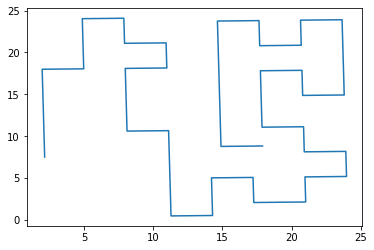

In [11]:
from matplotlib import pyplot as plt

positions = oracle_data['positions']
coords = [[i[0], i[2]] for i in positions]

x, y = [], []
for coord in coords:
    x.append(coord[0])
    y.append(coord[1])

plt.plot(x, y)
plt.show()

In [12]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i : (i + seq_length)]
        _y = data[i + seq_length]  # _y = data[i+seq_length] (target)
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)  # train, val. data

def create_data(seq_length, data, shuffle = True):
    
    positions = data['positions']    
    coords = [[i[0], i[2]] for i in positions]
    training_data = coords

    x, y = sliding_windows(training_data, seq_length)

    # one method of performing the training and validation split
    train_size = int(len(y) * 0.80)
    test_size = len(y) - train_size


    # shuffle data first before splitting
    if shuffle:
        idx_shuf = list(range(len(y)))
        random.shuffle(idx_shuf)
        x = [x[i] for i in idx_shuf]
        y = [y[i] for i in idx_shuf]

    # split data
    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size : len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size : len(y)])))
    
    return trainX, trainY, testX, testY

In [13]:
k = 6
print('sequence:', x[k])
print('label:', y[k])

print(len(y))

sequence: 2.1641372731802773
label: 7.4854865990430435
1195


In [22]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out1 = self.fc(h_out)
        #out2 = self.fc(h_out)

        return out1 #, out2

# change weight initialization (kaiming_normal_
    
num_epochs = 2000
learning_rate = 0.001

input_size = 2
hidden_size = 300
num_layers = 1

num_classes = 2
seq_length = 10

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)

In [23]:
value = 0

test_input = trainX[value:value+1]
print("input length:", len(test_input[0]))
print("input (trainX):", test_input)

#out1, out2 = lstm(test_input)
out1 = lstm(test_input)
print(out1)

print("outputs:", out1[0]) #
print("labels:", trainY[value:value+1])

print("")

#out1, out2 = lstm(trainX)
out1 = lstm(trainX)

print("length input (trainX):", len(trainX))
print("length outputs:", len(out1))
print("length labels:", len(trainY))

print("")
print("SUMMARY LSTM \n", summary(lstm, (600, 1, 2), device="cpu"))

NameError: name 'trainX' is not defined

In [24]:
def separate_coordinates(coords):

    coord1, coord2 = [], []
    for coord in coords:
        coord1.append(coord[0].tolist() * 10)
        coord2.append(coord[1].tolist() * 10)
        #coord2 = coord2 + list(coord[1].tolist())
        
    coord1 = torch.FloatTensor(coord1)
    coord2 = torch.FloatTensor(coord2)
        
    return coord1, coord2

coord1_trainY, coord2_trainY =  separate_coordinates(trainY)
coord1_testY, coord2_testY =  separate_coordinates(testY)

NameError: name 'trainY' is not defined

In [25]:
def plot_losses(test_loss, train_loss, num_epochs):
    
    for i in range(len(train_loss)):
        train_loss[i] = train_loss[i].item()
    
    font = 24
    hfont = {'fontname':'Helvetica'}
        
    plt.rcParams["figure.figsize"] = 20, 6
    plt.rcParams['axes.titlepad'] = 13 
    plt.rcParams['xtick.major.pad']='8' # axis distance
    plt.rcParams['ytick.major.pad']='8'
    
    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    
    with plt.style.context("seaborn-darkgrid"):
        
        plt.rcParams.update({"font.size": font})
        plt.plot(test_loss, color="slategray", linewidth=2)
        plt.plot(train_loss, color="red", linewidth=2)
        plt.legend(["Training Loss", "Validation Loss"])
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss")
        
        # plt.savefig('difficult_env_loss_epochs.pdf', bbox_inches="tight")
        plt.show()

def plot_euclidean_distance(train_dis, test_dis, num_epochs):
    
    
    for i in range(len(train_dis)):
        train_dis[i] = train_dis[i].item()
    
    #for i in range(len(test_dis)):
    #    test_dis[i] = test_dis[i].item()  

    font = 24
    hfont = {'fontname':'Helvetica'}
        
    plt.rcParams["figure.figsize"] = 20, 6
    plt.rcParams['axes.titlepad'] = 13 
    plt.rcParams['xtick.major.pad']='8' # axis distance
    plt.rcParams['ytick.major.pad']='8'
    
    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.rcParams.update({"font.size": font})

    with plt.style.context("seaborn-darkgrid"):
        plt.plot(train_dis, label="Training", linewidth=3, color="tab:blue")
        plt.plot(test_dis, c='indianred', label="Validation", linewidth=3)
        plt.title("Difficult Environment", fontsize=font)
        plt.legend(fontsize=font)
        plt.xlabel("Epochs", fontsize=font, **hfont)
        plt.ylabel("Euclidean distance", fontsize=font, **hfont)
        
        plt.xlim(xmax = num_epochs+5, xmin = -5)
        
        #plt.savefig('difficult_env_euclidean_distance_epochs.pdf', bbox_inches="tight")
        
        plt.show()

In [26]:
def train_lstm(num_epochs, trainX, trainY, testX, testY, seq_length):
    
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    train_loss_collector = []
    train_distance_collector = []
    test_loss_collector = []
    test_distance_collector = []

    for epoch in range(num_epochs):

        optimizer.zero_grad()
        output = lstm(trainX)
        loss = criterion(output, trainY)
        loss.backward()

        # compute euclidean distance 
        train_dist = 0
        for idx, _ in enumerate(trainY):
            train_dist += ((output[idx][0] - trainY[idx][0])**2 + (output[idx][1] - trainY[idx][1])**2) ** 0.5
        train_dist = train_dist/len(trainY)

        with torch.no_grad():
            output_test = lstm(testX)
            loss_test = criterion(output_test, testY)

            test_dist = 0
            for idx, _ in enumerate(testY):
                test_dist += ((output_test[idx][0] - testY[idx][0])**2 + (output_test[idx][1] - testY[idx][1])**2) ** 0.5
            test_dist = test_dist/len(testY)

        train_loss_collector.append(loss)
        train_distance_collector.append(train_dist)
        test_loss_collector.append(loss_test)
        test_distance_collector.append(test_dist)

        optimizer.step()
        if epoch % (num_epochs/20) == 0:
            print("Epoch: %d, train loss: %1.5f, train distance: %1.5f, test loss: %1.5f, test distance: %1.5f" % (epoch, loss.item(), train_dist, loss_test.item(), test_dist))
        
    return train_loss_collector, train_distance_collector, test_loss_collector, test_distance_collector
            
            

hidden size is  20
Epoch: 0, train loss: 160.29199, train distance: 17.24976, test loss: 159.67433, test distance: 17.17388
Epoch: 25, train loss: 159.24670, train distance: 17.19140, test loss: 158.63484, test distance: 17.11578
Epoch: 50, train loss: 158.18562, train distance: 17.13195, test loss: 157.58089, test distance: 17.05663
Epoch: 75, train loss: 157.09352, train distance: 17.07061, test loss: 156.50200, test distance: 16.99585
Epoch: 100, train loss: 155.98691, train distance: 17.00798, test loss: 155.41745, test distance: 16.93424
Epoch: 125, train loss: 154.89601, train distance: 16.94541, test loss: 154.35524, test distance: 16.87318
Epoch: 150, train loss: 153.82892, train distance: 16.88348, test loss: 153.31873, test distance: 16.81293
Epoch: 175, train loss: 152.77145, train distance: 16.82142, test loss: 152.29242, test distance: 16.75271
Epoch: 200, train loss: 151.70723, train distance: 16.75850, test loss: 151.25777, test distance: 16.69156
Epoch: 225, train loss:

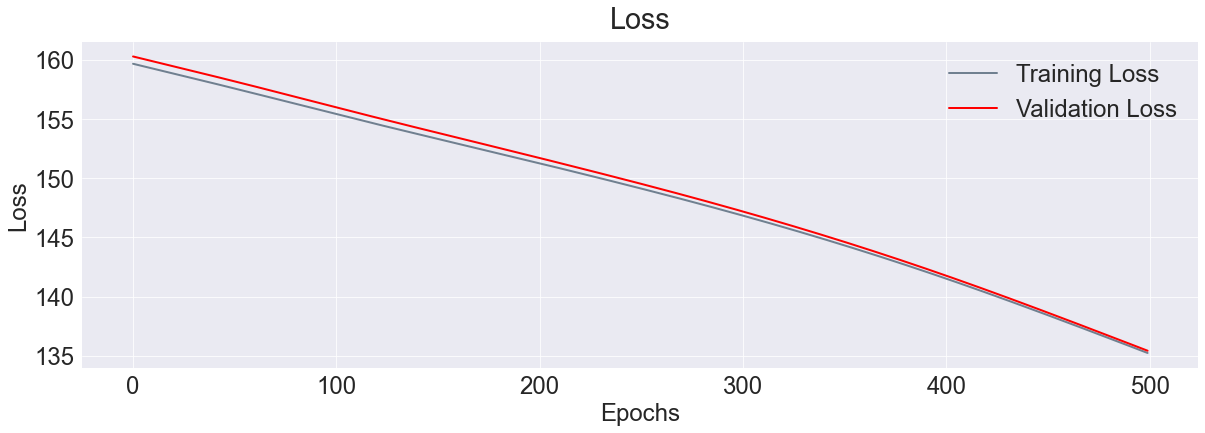

In [ ]:
import time

collect_acc_test = []
collect_acc_train = []
collect_loss_test = []
collect_loss_train = []

data = oracle_reversed_random_data_small
trainX, trainY, testX, testY = create_data(seq_length, data, shuffle = True)

for i in range(1, 6):
    
    t = time.time()
    
    if i == 1:
         hidden_size = 20
    if i == 2: 
         hidden_size = 50
    if i == 3: 
         hidden_size = 100
    if i == 4: 
         hidden_size = 300
    if i == 5: 
         hidden_size = 500
    
    learning_rate = 0.0001
   
    num_epochs = 500
    
    print('hidden size is ', hidden_size)
    train_loss_collector, train_distance_collector, test_loss_collector, test_distance_collector = train_lstm(num_epochs, trainX, trainY, testX, testY, seq_length)

    collect_acc_test.append(test_distance_collector)
    collect_acc_train.append(train_distance_collector)
    collect_loss_test.append(test_loss_collector)
    collect_loss_train.append(train_loss_collector)
    
    elapsed = time.time() - t
    print('############## ', elapsed, '  ##############')
    
    plot_losses(test_loss_collector, train_loss_collector, num_epochs)
    plot_euclidean_distance(train_distance_collector, test_distance_collector, num_epochs)

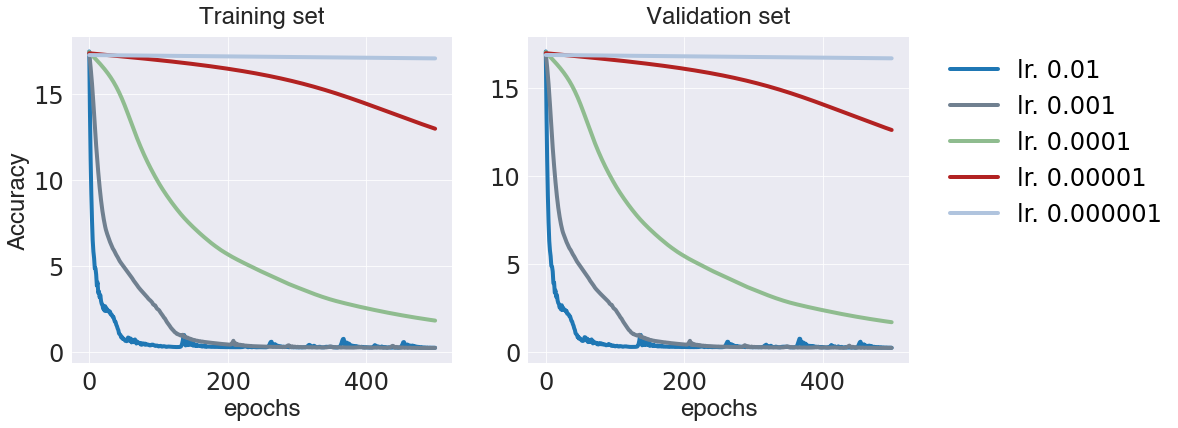

In [40]:
font = 24
hfont = {'fontname':'Helvetica'}

#plt.rcParams["figure.figsize"] = 25, 5.5
plt.rcParams.update({"font.size": font})
plt.rcParams['axes.titlepad'] = 13 
plt.rcParams['xtick.major.pad']='8' # axis distance
plt.rcParams['ytick.major.pad']='8'

plt.figure(figsize=(15, 6))

with plt.style.context("seaborn-darkgrid"):

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.title("Model performance", fontsize=font)
    plt.ylabel("validation accuracy", fontsize=font, **hfont)
    plt.xlabel("n-step distance", fontsize=font, **hfont)

    # easy
    plt.subplot(1, 2, 1)
    y1, = plt.plot(collect_acc_train[0], linestyle='solid', c='tab:blue', label='lr. 0.01', linewidth=4.0)
    y2, = plt.plot(collect_acc_train[1], c='slategray', linestyle='solid', label='lr. 0.001', linewidth=4.0)
    y3, = plt.plot(collect_acc_train[2], c='darkseagreen', linestyle='solid', label='lr. 0.0001', linewidth=4.0)
    y4, = plt.plot(collect_acc_train[3], c='firebrick', linestyle='solid', label='lr. 0.00001', linewidth=4.0)
    y5, = plt.plot(collect_acc_train[4], c='lightsteelblue', linestyle='solid', label='lr. 0.000001', linewidth=4.0)
    
    plt.ylabel("Accuracy", fontsize=font, **hfont)
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Training set", fontsize=font, **hfont)
        
    plt.subplot(1, 2, 2)
    plt.plot(collect_acc_test[0], linestyle='solid', c='tab:blue', label='Length 1', linewidth=4.0)
    plt.plot(collect_acc_test[1], c='slategray', linestyle='solid', label='Length 9', linewidth=4.0)
    plt.plot(collect_acc_test[2], c='darkseagreen', linestyle='solid', label='Length 17', linewidth=4.0)
    plt.plot(collect_acc_test[3], c='firebrick', linestyle='solid', label='Length 17', linewidth=4.0)
    plt.plot(collect_acc_test[4], c='lightsteelblue', linestyle='solid', label='Length 17', linewidth=4.0)
    
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Validation set", fontsize=font, **hfont)
    
plt.legend(handles=[y1, y2, y3, y4, y5], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.savefig('lstm_coord_pred_learning_rate.pdf', bbox_inches="tight")




sequence lenth 1 easy environment
Epoch: 0, train loss: 249.22043, train distance: 21.54571, test loss: 242.49709, test distance: 21.20067
Epoch: 25, train loss: 181.62926, train distance: 18.36580, test loss: 176.86343, test distance: 18.07433
Epoch: 50, train loss: 79.83534, train distance: 12.06755, test loss: 78.09325, test distance: 11.89266
Epoch: 75, train loss: 30.61193, train distance: 7.25468, test loss: 30.81585, test distance: 7.28260
Epoch: 100, train loss: 23.97201, train distance: 6.36151, test loss: 24.40841, test distance: 6.45132
Epoch: 125, train loss: 16.37784, train distance: 5.22618, test loss: 16.61022, test distance: 5.28799
Epoch: 150, train loss: 9.32152, train distance: 3.88467, test loss: 9.47312, test distance: 3.94392
Epoch: 175, train loss: 4.76331, train distance: 2.71766, test loss: 4.84077, test distance: 2.76131
Epoch: 200, train loss: 2.86435, train distance: 2.08664, test loss: 2.91203, test distance: 2.11486
Epoch: 225, train loss: 2.19357, train 

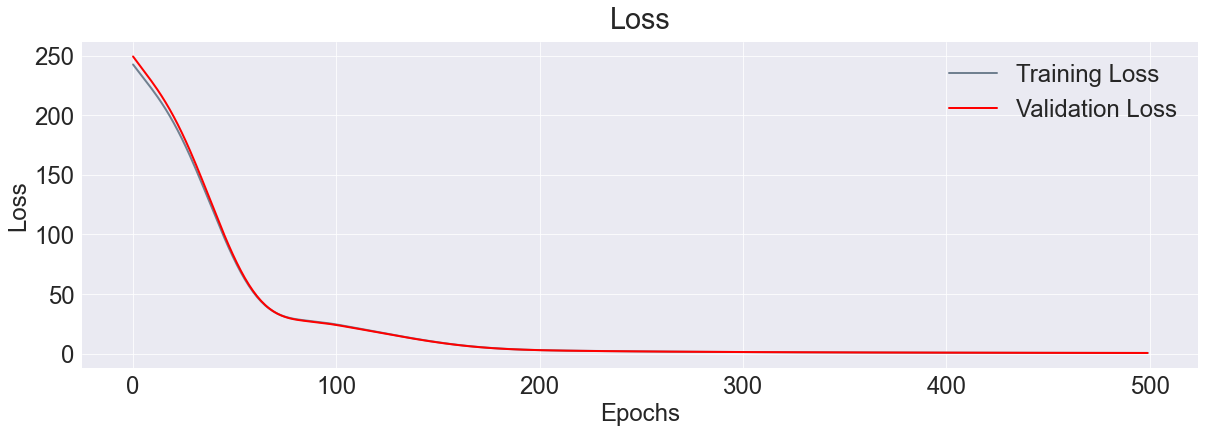

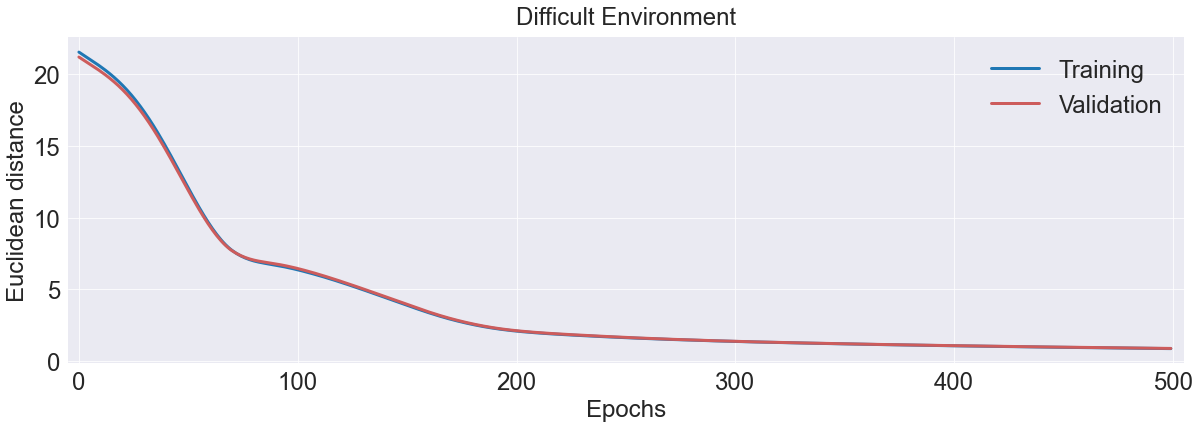


sequence lenth 11 easy environment
Epoch: 0, train loss: 246.35472, train distance: 21.42525, test loss: 247.38188, test distance: 21.53274
Epoch: 25, train loss: 57.93308, train distance: 9.92237, test loss: 57.80181, test distance: 9.94684
Epoch: 50, train loss: 34.52697, train distance: 7.70953, test loss: 34.02264, test distance: 7.67095
Epoch: 75, train loss: 27.53838, train distance: 6.81448, test loss: 27.14440, test distance: 6.78152
Epoch: 100, train loss: 20.51344, train distance: 5.75697, test loss: 20.27528, test distance: 5.73277
Epoch: 125, train loss: 10.94857, train distance: 3.95263, test loss: 11.08345, test distance: 3.99134
Epoch: 150, train loss: 4.21481, train distance: 2.32645, test loss: 4.20847, test distance: 2.33498
Epoch: 175, train loss: 1.85090, train distance: 1.49262, test loss: 1.81827, test distance: 1.49848
Epoch: 200, train loss: 1.00273, train distance: 1.13123, test loss: 0.96659, test distance: 1.12237
Epoch: 225, train loss: 0.59868, train dista

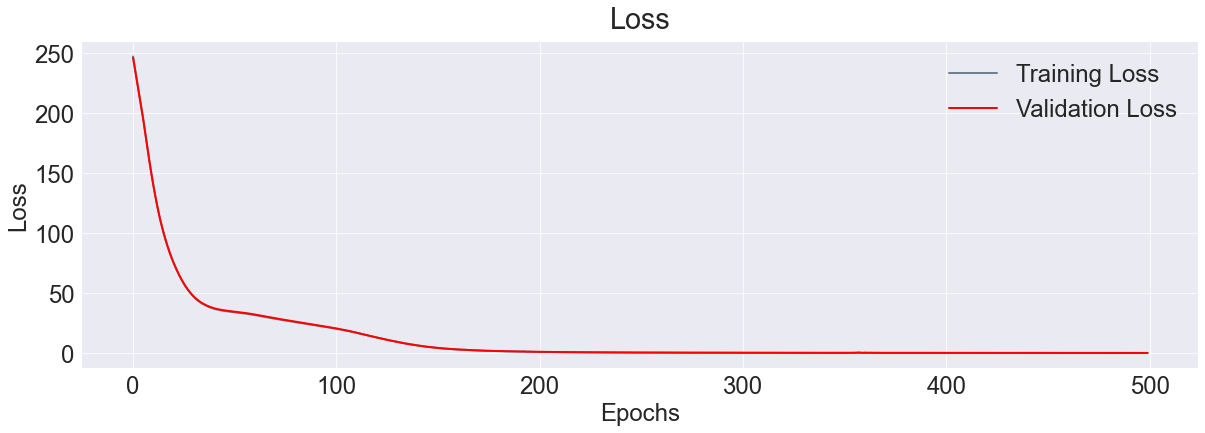

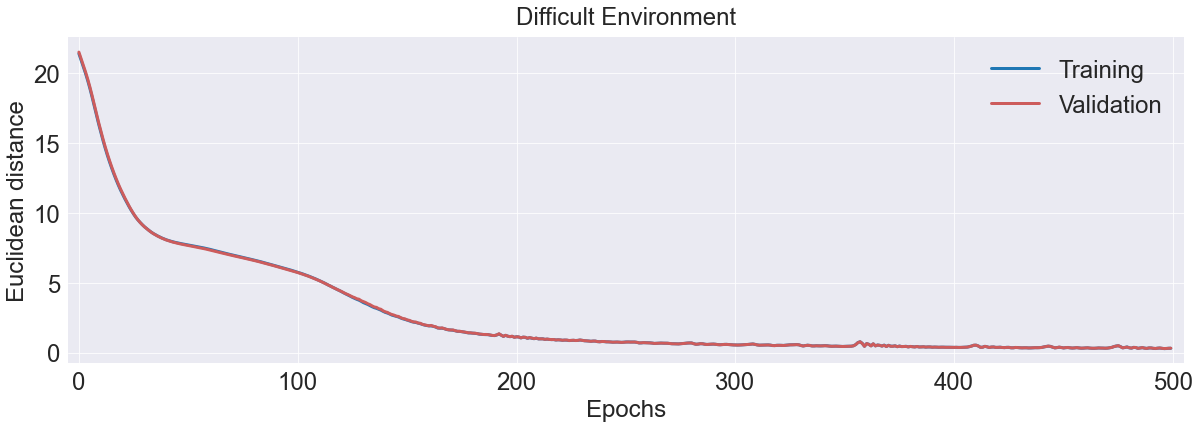


sequence lenth 21 easy environment
Epoch: 0, train loss: 245.36540, train distance: 21.39192, test loss: 246.88486, test distance: 21.48165
Epoch: 25, train loss: 58.05714, train distance: 9.87694, test loss: 59.17395, test distance: 10.08347
Epoch: 50, train loss: 30.02929, train distance: 7.19582, test loss: 30.51353, test distance: 7.23443
Epoch: 75, train loss: 22.55992, train distance: 6.10225, test loss: 22.81776, test distance: 6.13461
Epoch: 100, train loss: 14.89696, train distance: 4.76829, test loss: 15.15380, test distance: 4.85068
Epoch: 125, train loss: 7.05831, train distance: 3.09276, test loss: 7.13139, test distance: 3.16831
Epoch: 150, train loss: 2.75622, train distance: 1.82270, test loss: 2.84532, test distance: 1.90607
Epoch: 175, train loss: 1.29022, train distance: 1.19068, test loss: 1.29409, test distance: 1.20867
Epoch: 200, train loss: 0.73847, train distance: 0.88145, test loss: 0.73435, test distance: 0.89552
Epoch: 225, train loss: 0.48068, train distan

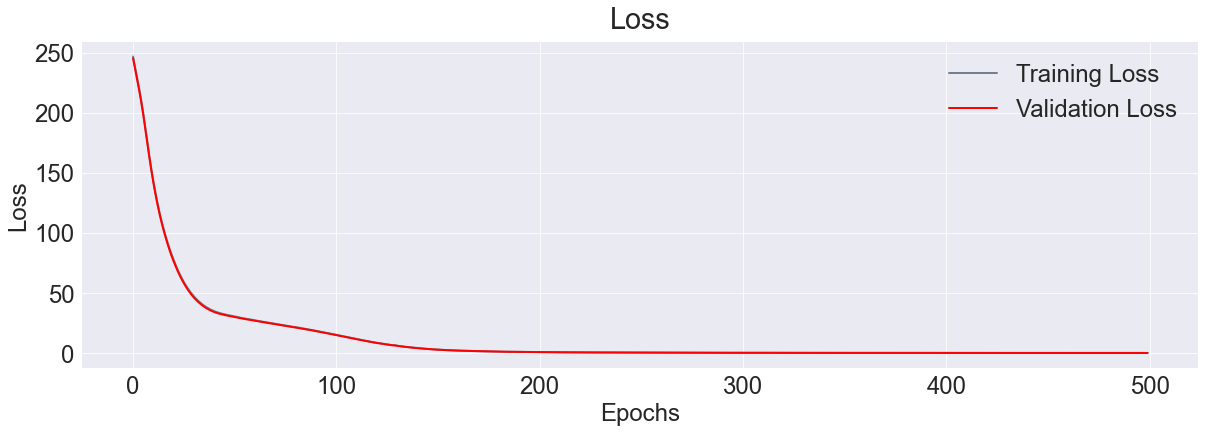

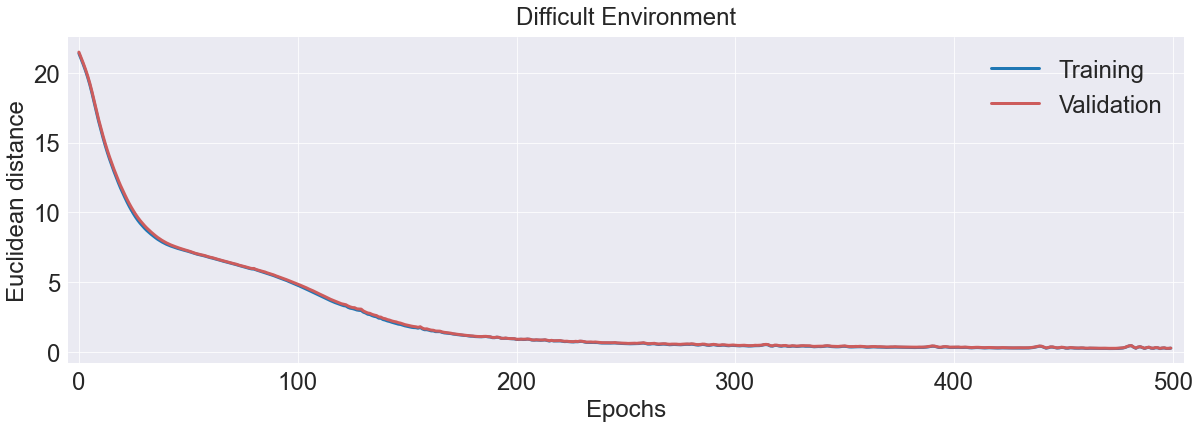


sequence lenth 1 medium environment
Epoch: 0, train loss: 158.59853, train distance: 17.16506, test loss: 165.66313, test distance: 17.54651
Epoch: 25, train loss: 111.58929, train distance: 14.39062, test loss: 116.33177, test distance: 14.69495
Epoch: 50, train loss: 49.30956, train distance: 9.41436, test loss: 51.11197, test distance: 9.59200
Epoch: 75, train loss: 21.44147, train distance: 5.94844, test loss: 21.21929, test distance: 5.91588
Epoch: 100, train loss: 12.40602, train distance: 4.45632, test loss: 11.78781, test distance: 4.31764
Epoch: 125, train loss: 5.59372, train distance: 2.97699, test loss: 5.40813, test distance: 2.91706
Epoch: 150, train loss: 2.10223, train distance: 1.80569, test loss: 2.10679, test distance: 1.81336
Epoch: 175, train loss: 1.22003, train distance: 1.44179, test loss: 1.25148, test distance: 1.46139
Epoch: 200, train loss: 0.95515, train distance: 1.26631, test loss: 0.98645, test distance: 1.28943
Epoch: 225, train loss: 0.77548, train di

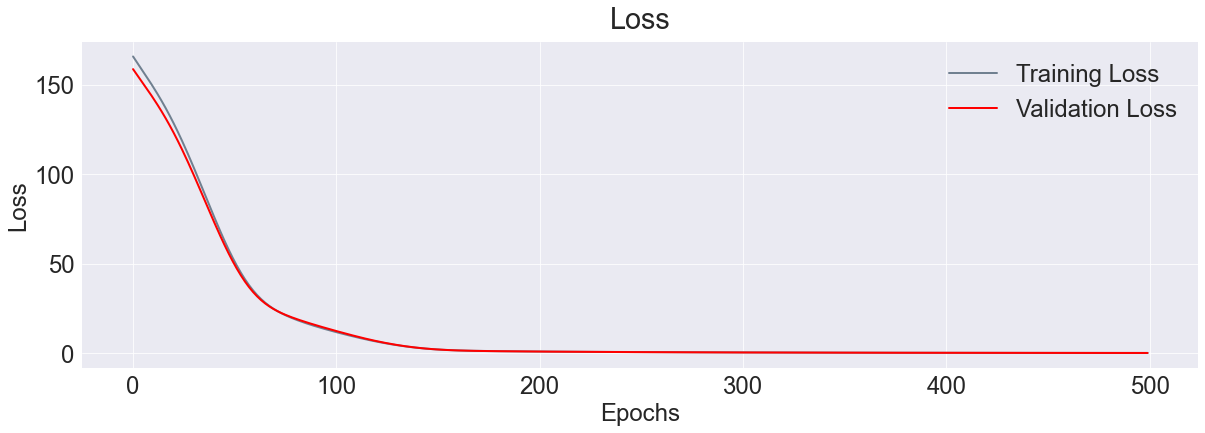

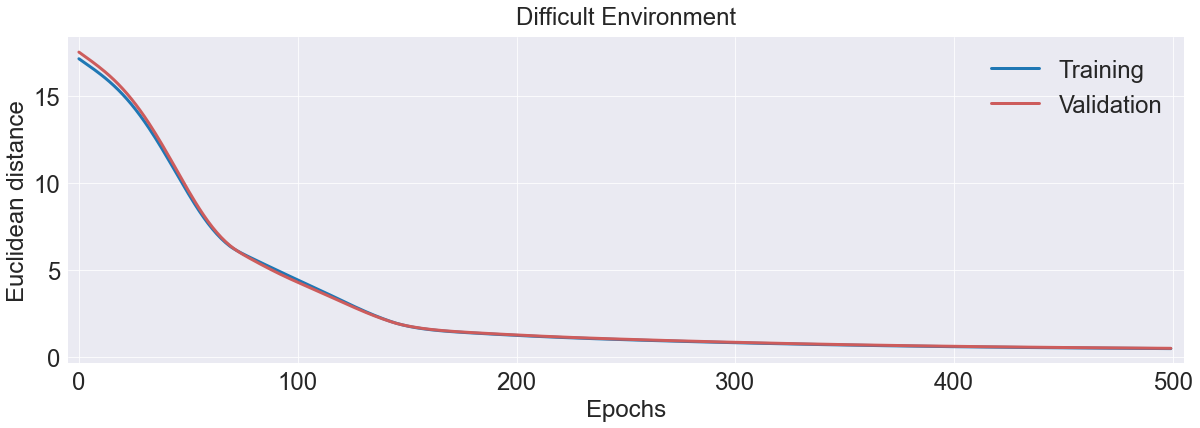


sequence lenth 11 medium environment
Epoch: 0, train loss: 161.45317, train distance: 17.34785, test loss: 156.06427, test distance: 17.07715
Epoch: 25, train loss: 26.85091, train distance: 6.60875, test loss: 25.36327, test distance: 6.35862
Epoch: 50, train loss: 8.62288, train distance: 3.64388, test loss: 8.41211, test distance: 3.57147
Epoch: 75, train loss: 4.26878, train distance: 2.48051, test loss: 4.10430, test distance: 2.42888
Epoch: 100, train loss: 1.29365, train distance: 1.37017, test loss: 1.25152, test distance: 1.35285
Epoch: 125, train loss: 0.41435, train distance: 0.76893, test loss: 0.41599, test distance: 0.78300
Epoch: 150, train loss: 0.20662, train distance: 0.55778, test loss: 0.21283, test distance: 0.57278
Epoch: 175, train loss: 0.10996, train distance: 0.41258, test loss: 0.11221, test distance: 0.42118
Epoch: 200, train loss: 0.07257, train distance: 0.34616, test loss: 0.07363, test distance: 0.35036
Epoch: 225, train loss: 0.06442, train distance: 0

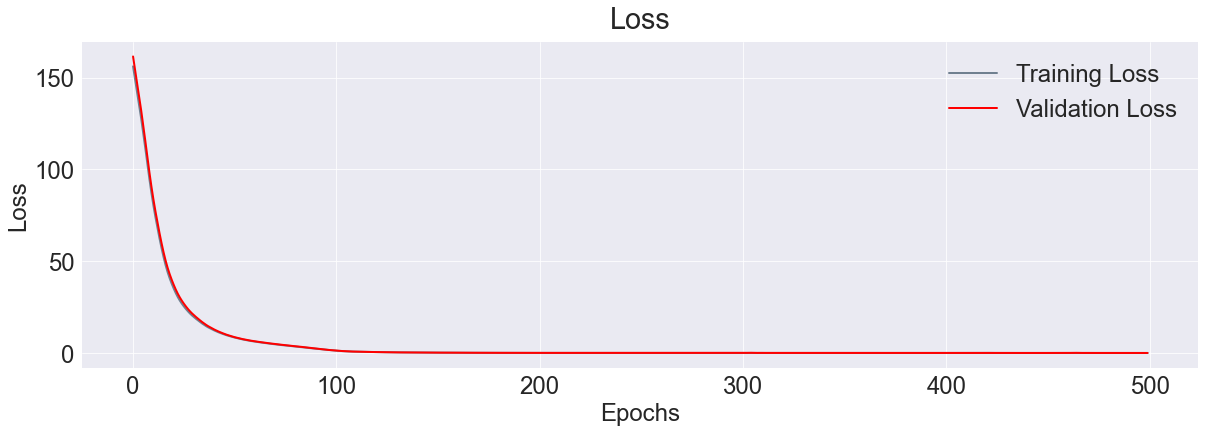

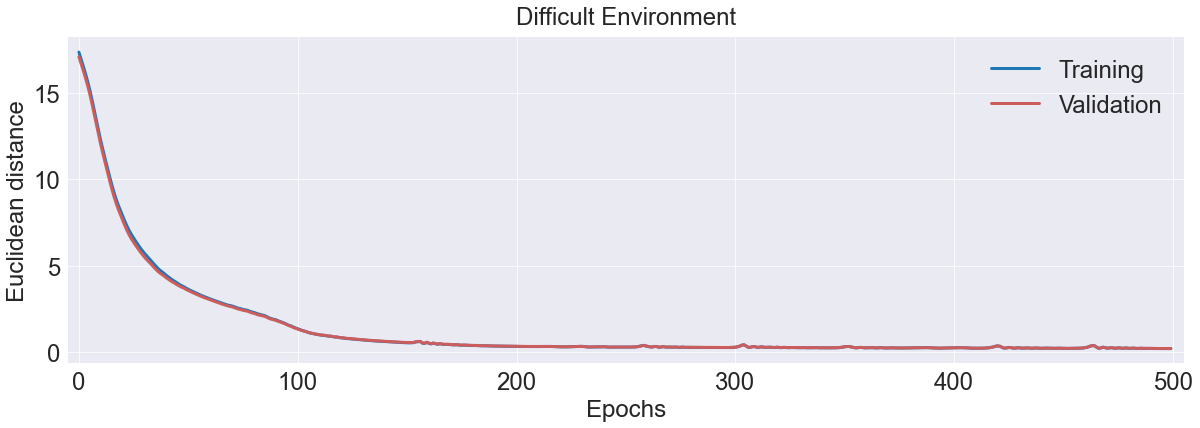


sequence lenth 21 medium environment
Epoch: 0, train loss: 159.89870, train distance: 17.26356, test loss: 168.92030, test distance: 17.75097
Epoch: 25, train loss: 24.32184, train distance: 6.17335, test loss: 26.52675, test distance: 6.41787
Epoch: 50, train loss: 7.59266, train distance: 3.29462, test loss: 7.79157, test distance: 3.31143
Epoch: 75, train loss: 3.63286, train distance: 2.31501, test loss: 3.69008, test distance: 2.32671
Epoch: 100, train loss: 0.76160, train distance: 1.02874, test loss: 0.88055, test distance: 1.10311
Epoch: 125, train loss: 0.28978, train distance: 0.63970, test loss: 0.34102, test distance: 0.68561
Epoch: 150, train loss: 0.18548, train distance: 0.51621, test loss: 0.21547, test distance: 0.55060
Epoch: 175, train loss: 0.11602, train distance: 0.40321, test loss: 0.13754, test distance: 0.43789
Epoch: 200, train loss: 0.08140, train distance: 0.33220, test loss: 0.09711, test distance: 0.36247
Epoch: 225, train loss: 0.06326, train distance: 0

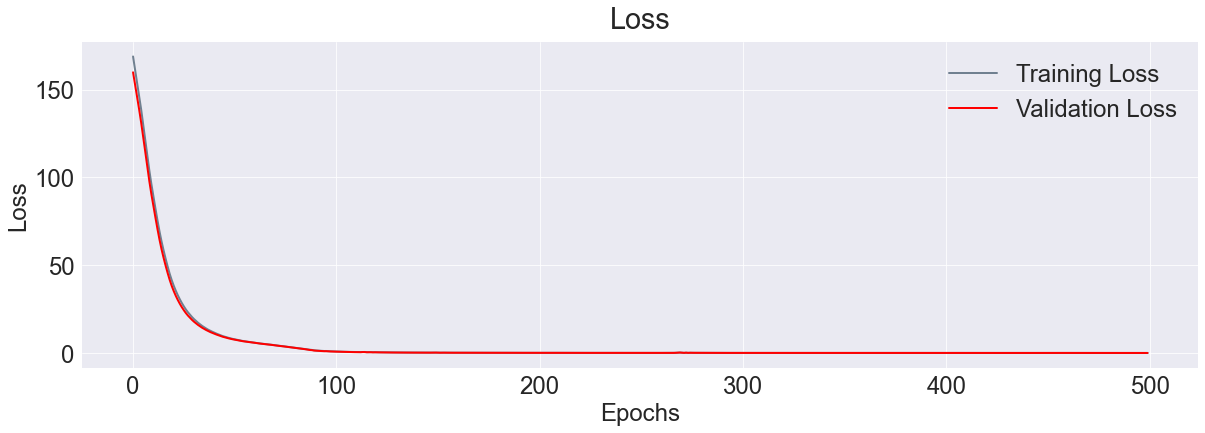

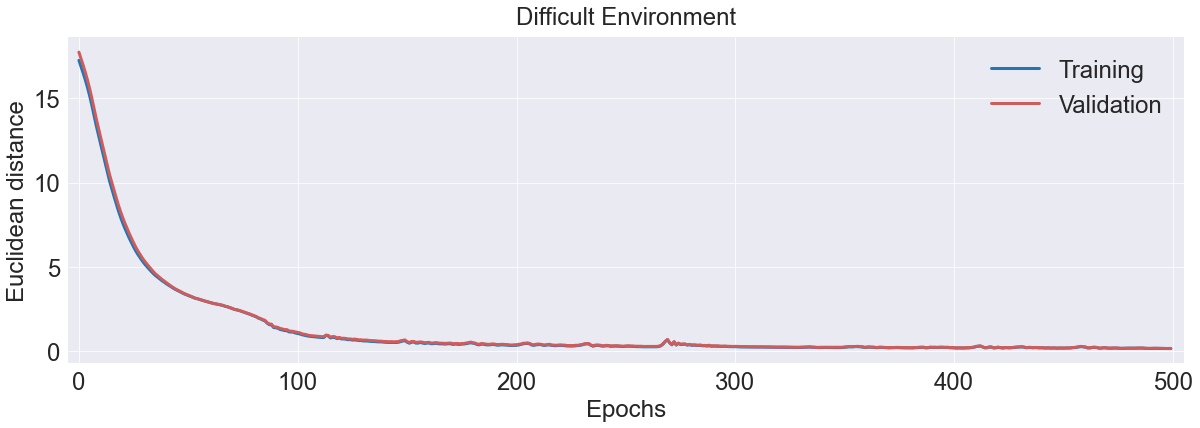


sequence lenth 1 difficult environment
Epoch: 0, train loss: 4.16784, train distance: 2.50672, test loss: 4.38031, test distance: 2.58375
Epoch: 25, train loss: 2.69814, train distance: 2.03035, test loss: 2.84240, test distance: 2.08662
Epoch: 50, train loss: 0.98250, train distance: 1.27746, test loss: 1.03688, test distance: 1.30287
Epoch: 75, train loss: 0.42318, train distance: 0.80396, test loss: 0.43021, test distance: 0.81391
Epoch: 100, train loss: 0.20050, train distance: 0.56762, test loss: 0.19998, test distance: 0.56885
Epoch: 125, train loss: 0.06959, train distance: 0.32227, test loss: 0.06402, test distance: 0.31098
Epoch: 150, train loss: 0.03590, train distance: 0.21384, test loss: 0.03109, test distance: 0.19966
Epoch: 175, train loss: 0.02659, train distance: 0.18736, test loss: 0.02340, test distance: 0.17542
Epoch: 200, train loss: 0.02062, train distance: 0.16651, test loss: 0.01851, test distance: 0.15671
Epoch: 225, train loss: 0.01621, train distance: 0.14848

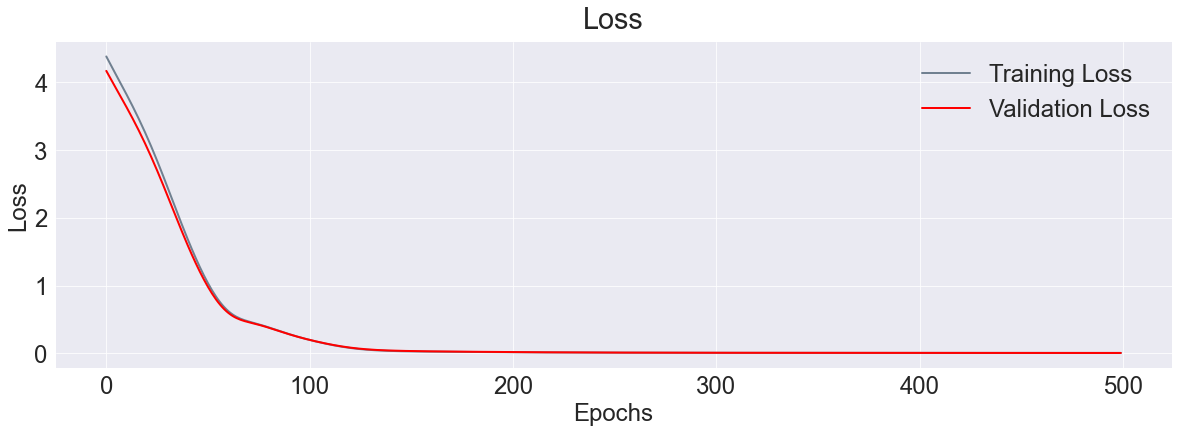

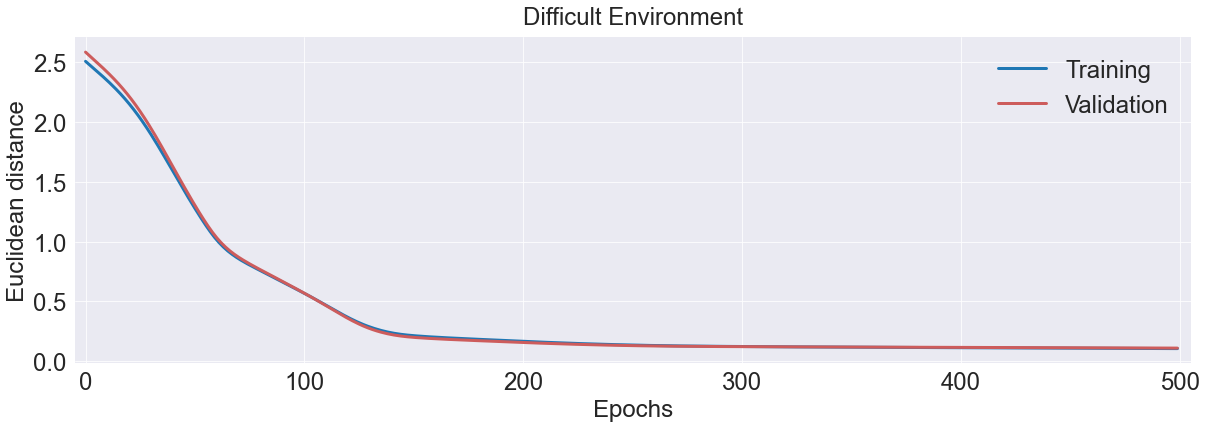


sequence lenth 11 difficult environment
Epoch: 0, train loss: 4.33301, train distance: 2.56426, test loss: 4.23825, test distance: 2.54882
Epoch: 25, train loss: 0.21855, train distance: 0.60032, test loss: 0.21507, test distance: 0.59518
Epoch: 50, train loss: 0.08974, train distance: 0.37568, test loss: 0.09199, test distance: 0.38327
Epoch: 75, train loss: 0.03408, train distance: 0.22635, test loss: 0.03696, test distance: 0.23724
Epoch: 100, train loss: 0.02635, train distance: 0.19841, test loss: 0.02904, test distance: 0.20859
Epoch: 125, train loss: 0.02287, train distance: 0.18176, test loss: 0.02507, test distance: 0.19048
Epoch: 150, train loss: 0.02064, train distance: 0.17088, test loss: 0.02260, test distance: 0.17925
Epoch: 175, train loss: 0.01903, train distance: 0.16276, test loss: 0.02088, test distance: 0.17117
Epoch: 200, train loss: 0.01773, train distance: 0.15650, test loss: 0.01948, test distance: 0.16498
Epoch: 225, train loss: 0.01660, train distance: 0.1511

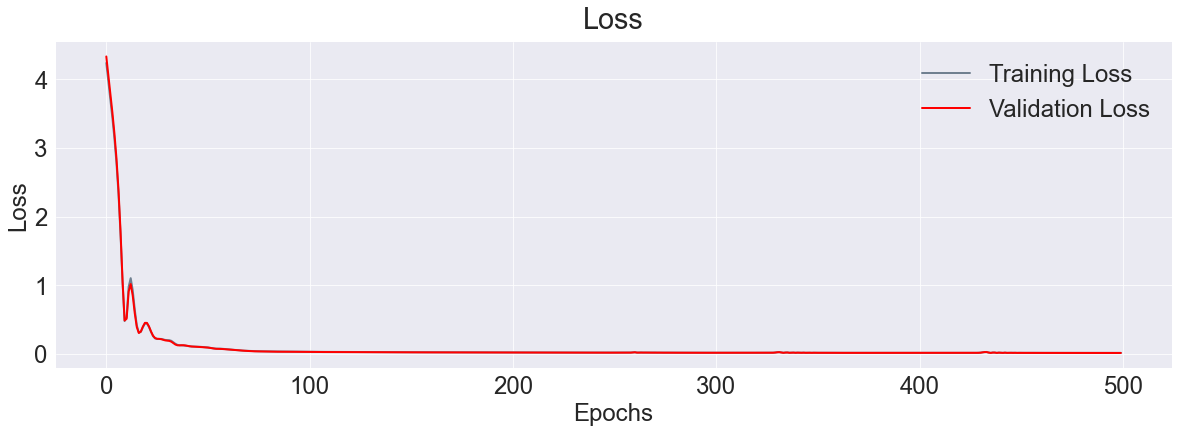

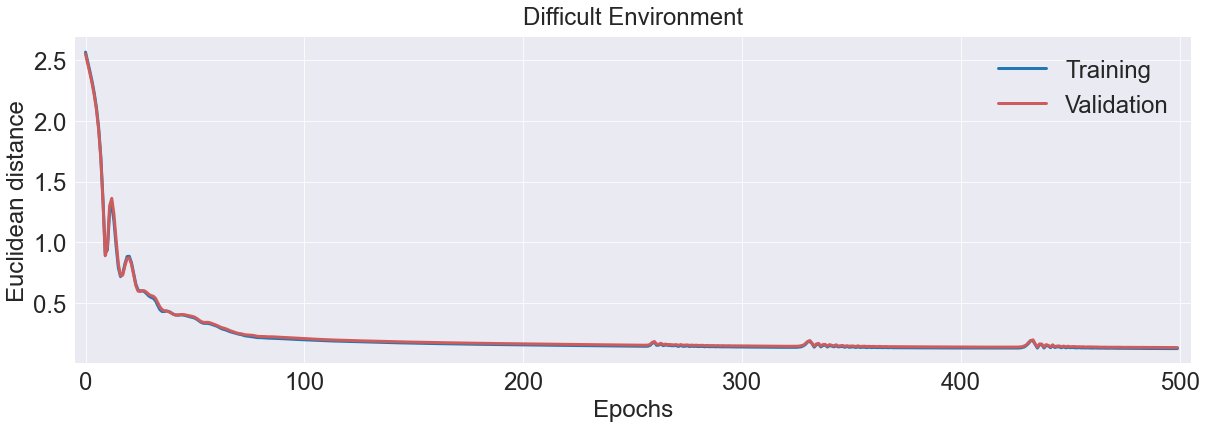


sequence lenth 21 difficult environment
Epoch: 0, train loss: 4.17927, train distance: 2.51427, test loss: 4.14742, test distance: 2.49548
Epoch: 25, train loss: 0.24624, train distance: 0.63208, test loss: 0.23885, test distance: 0.61697
Epoch: 50, train loss: 0.10204, train distance: 0.40335, test loss: 0.10193, test distance: 0.39910
Epoch: 75, train loss: 0.04280, train distance: 0.25222, test loss: 0.04312, test distance: 0.24660
Epoch: 100, train loss: 0.02521, train distance: 0.18951, test loss: 0.02970, test distance: 0.20292
Epoch: 125, train loss: 0.02079, train distance: 0.17015, test loss: 0.02406, test distance: 0.18081
Epoch: 150, train loss: 0.01795, train distance: 0.15813, test loss: 0.02046, test distance: 0.16792
Epoch: 175, train loss: 0.01619, train distance: 0.15115, test loss: 0.01793, test distance: 0.15831
Epoch: 200, train loss: 0.01501, train distance: 0.14479, test loss: 0.01674, test distance: 0.15208
Epoch: 225, train loss: 0.01419, train distance: 0.1404

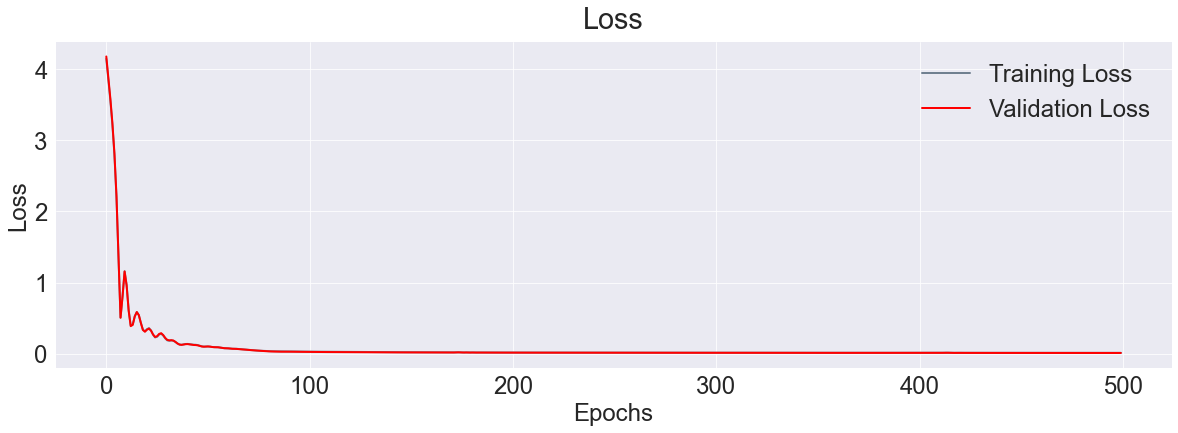

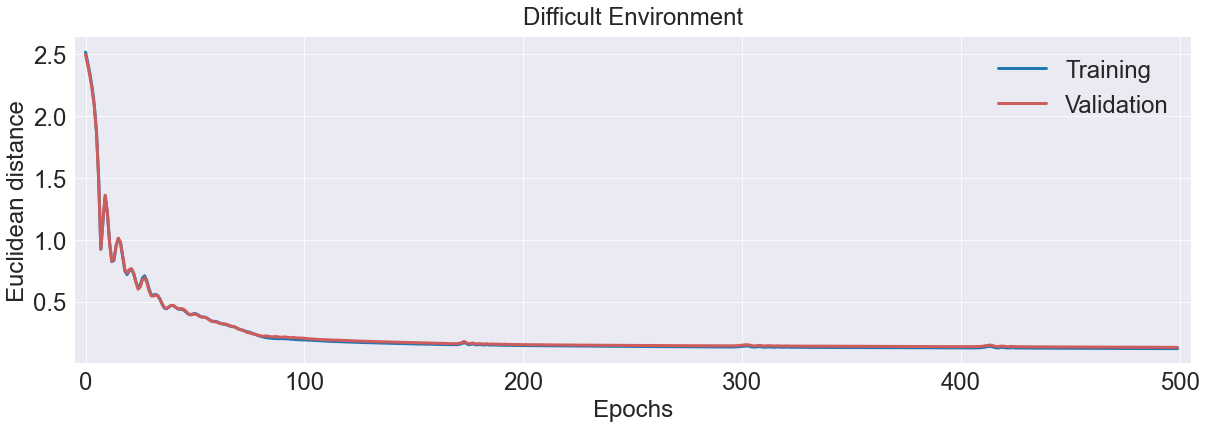

In [31]:
def run_all_environments(environments):

    meta_meta_train_distance_collector = []
    meta_meta_test_distance_collector = []

    for idx, data in enumerate(environments):

        learning_rate = 0.001

        input_size = 2
        hidden_size = 300
        num_layers = 1

        num_classes = 2

        num_epochs = 500

        meta_train_distance_collector = []
        meta_test_distance_collector = []

        for i in range(1, 22, 10):

            print('')
            if idx == 0: print('sequence lenth', i, 'easy environment')
            if idx == 1: print('sequence lenth', i, 'medium environment')
            if idx == 2: print('sequence lenth', i, 'difficult environment')
            seq_length = i
            shuffle = True

            trainX, trainY, testX, testY = create_data(seq_length, data, shuffle = True)

            train_loss_collector, train_distance_collector, test_loss_collector, test_distance_collector = train_lstm(num_epochs, trainX, trainY, testX, testY, seq_length)

            plot_losses(test_loss_collector, train_loss_collector, num_epochs)
            plot_euclidean_distance(train_distance_collector, test_distance_collector, num_epochs)

            meta_train_distance_collector.append(train_distance_collector)
            meta_test_distance_collector.append(test_distance_collector)
        
        meta_meta_train_distance_collector.append(meta_train_distance_collector)
        meta_meta_test_distance_collector.append(meta_test_distance_collector)
        
    return meta_meta_train_distance_collector, meta_meta_test_distance_collector

environments = [oracle_reversed_data, oracle_reversed_random_data_small, tmaze_random_reverse_data]

# 3 environments x 3 sequence lenghts x actual runs
train_distances, test_distances = run_all_environments(environments)



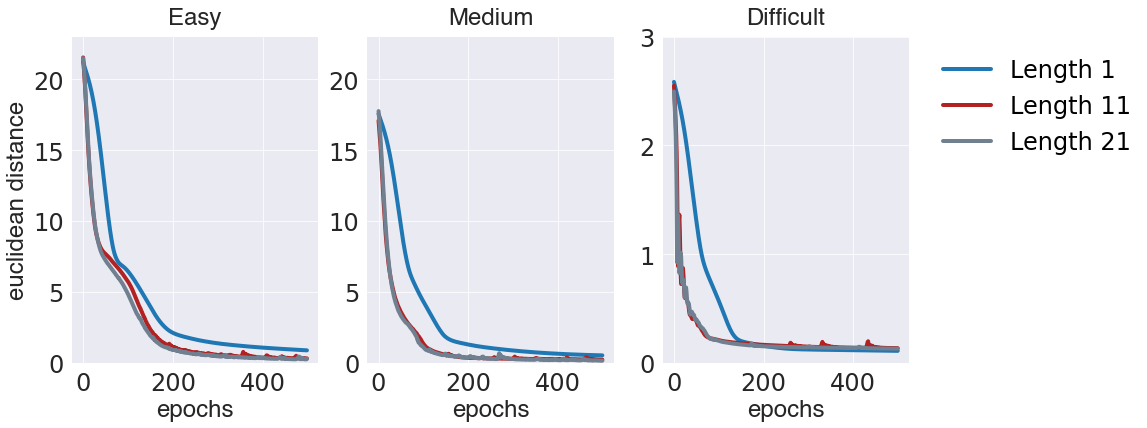

In [34]:
font = 24
hfont = {'fontname':'Helvetica'}

#plt.rcParams["figure.figsize"] = 25, 5.5
plt.rcParams.update({"font.size": font})
plt.rcParams['axes.titlepad'] = 13 
plt.rcParams['xtick.major.pad']='8' # axis distance
plt.rcParams['ytick.major.pad']='8'

plt.figure(figsize=(15, 6))

with plt.style.context("seaborn-darkgrid"):

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.title("Model performance", fontsize=font)
    plt.ylabel("validation accuracy", fontsize=font, **hfont)
    plt.xlabel("n-step distance", fontsize=font, **hfont)

    # easy
    plt.subplot(1, 3, 1)
    y1, = plt.plot(test_distances[0][0], linestyle='solid', c='tab:blue', label='Length 1', linewidth=4.0)
    y2, = plt.plot(test_distances[0][1], c='firebrick', linestyle='solid', label='Length 11', linewidth=4.0)
    y3, = plt.plot(test_distances[0][2], c='slategray', linestyle='solid', label='Length 21', linewidth=4.0)
    
    #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.ylim(ymax = 23, ymin = 0)
    plt.yticks(np.arange(0, 22.5+1, 5.0))
    plt.ylabel("euclidean distance", fontsize=font, **hfont)
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Easy", fontsize=font, **hfont)
        
    plt.subplot(1, 3, 2)
    plt.plot(test_distances[1][0], linestyle='solid', c='tab:blue', label='Length 1', linewidth=4.0)
    plt.plot(test_distances[1][1], c='firebrick', linestyle='solid', label='Length 9', linewidth=4.0)
    plt.plot(test_distances[1][2], c='slategray', linestyle='solid', label='Length 17', linewidth=4.0)
    
    #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.ylim(ymax = 23, ymin = 0)
    plt.yticks(np.arange(0, 22.5+1, 5.0))
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Medium", fontsize=font, **hfont)

    plt.subplot(1, 3, 3)
    plt.plot(test_distances[2][0], linestyle='solid', c='tab:blue', label='Length 1', linewidth=4.0)
    plt.plot(test_distances[2][1], c='firebrick', linestyle='solid', label='Length 9', linewidth=4.0)
    plt.plot(test_distances[2][2], c='slategray', linestyle='solid', label='Length 17', linewidth=4.0)
    
    #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.ylim(ymax = 3, ymin = 0)
    plt.yticks(np.arange(0, 3+0.1, 1))
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Difficult", fontsize=font, **hfont)
    
plt.legend(handles=[y1, y2, y3], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.savefig('lstm_coordinate_pred_test_set_shuffle_True.pdf', bbox_inches="tight")
plt.show()